In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mmcv.utils.config import Config
from mim.utils import DEFAULT_CACHE_DIR
from src.extensions.dataset.coco_custom import CocoOtcDataset
import os
from mmdet.core.visualization.image import imshow_gt_det_bboxes
from mmdet.datasets import build_dataset, get_loading_pipeline
from src.utils.neptune_utils import load_results
import pandas as pd
sns.set()
%matplotlib inline

In [3]:
cfg = Config.fromfile("~/.cache/mim/vfnet_r50_fpn_mstrain_2x_coco.py")
cfg.data.test.test_mode = True
cfg.data.test.type = "CocoOtcDataset"
if cfg.get('custom_imports', None):
    from mmcv.utils import import_modules_from_strings
    import_modules_from_strings(**cfg['custom_imports'])

cfg.data.test.pop('samples_per_gpu', 0)
cfg.data.test.pipeline = get_loading_pipeline(cfg.data.train.pipeline)
dataset = build_dataset(cfg.data.test)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [4]:
oc_costs = {}
results = {}
for model_name in ["VFNet"]:#["DETR", "Faster-RCNN", "VFNet", "RetinaNet", "YOLOF"]:
    results[model_name] = load_results("EV-114", model_name)
    oc_costs[model_name] = dataset.eval_OTC(results[model_name], alpha=0.5, beta=0.6, get_average=False)
    

https://app.neptune.ai/mayu-ot/eval-detection/e/EV-114
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
OTC DONE (t=13.82s).


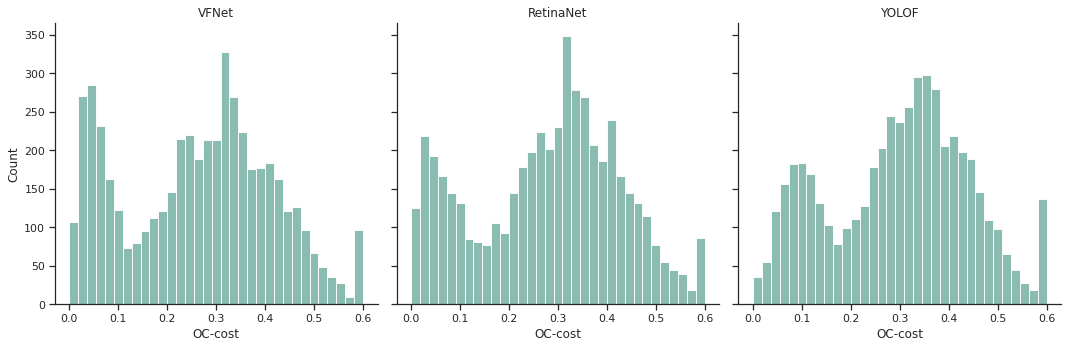

In [17]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
cp = sns.cubehelix_palette(rot=-.4)
data = {"model": [], "OC-cost": []}
for k, costs in oc_costs.items():
    if k not in ["VFNet", "RetinaNet", "YOLOF"]:
        continue
    data["model"] += [k] * len(costs)
    data["OC-cost"] += [x for x in costs]
df = pd.DataFrame(data)
g = sns.displot(data=df, x="OC-cost", col="model", color=cp[2])
g.set_titles("{col_name}")

In [35]:
def cvrt_result(bbox_result):
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    return bboxes, labels

cb_p = sns.color_palette("colorblind")
det_c = (np.asarray(cb_p[2])*255).astype(np.uint8)[::-1]
gt_c = (np.asarray(cb_p[3])*255).astype(np.uint8)[::-1]

sorted_idx = np.argsort([x for x in oc_costs["VFNet"]])

for s_idx in sorted_idx[::50]:
    dets = results["VFNet"][s_idx]
    cost = oc_costs["VFNet"][s_idx]
    data_info = dataset.prepare_train_img(s_idx)
    print(cost)
    f = draw_gt_det_bboxes(data_info["img"][:,:,::-1], dets, data_info["ann_info"])
    f.savefig(f"outputs/figs/realworld_examples/examples/{float(cost):.4}-{data_info['img_info']['id']}.pdf", bbox_inches="tight")
    plt.close()

0
0.012255385518074036
0.017538338899612427
0.021761402487754822
0.024912774562835693
0.02814222127199173
0.031095080077648163
0.03429914265871048
0.037883855402469635
0.041401371359825134
0.04476293921470642
0.0476861298084259
0.051327183842659
0.053902022540569305
0.05683474242687225
0.06050485670566559
0.06447492043177286
0.06869617601235707
0.07356946170330046
0.07920773327350616
0.08361209183931351
0.0900960514942805
0.0963679850101471
0.10450515896081924
0.11584096401929855
0.1266394754250844
0.1380992978811264
0.14871232956647873
0.15803681976265377
0.16680337607860565
0.1749495878815651
0.18296390984739574
0.18898999512195586
0.19835855215787887
0.20456470966339113
0.2122536446366991
0.21762708909809592
0.22205078236081385
0.22557062606016792
0.22951208998759587
0.23454864110265455
0.23819688984325948
0.24311203750280236
0.24706773857275643
0.251154912263155
0.2552182247241338
0.25987887879212695
0.2635350743929545
0.26893798361221943
0.27474408209323886
0.27874081035455067
0.2

In [34]:
from matplotlib.patches import Rectangle

def cvrt_result(bbox_result):
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    return bboxes, labels

def draw_bboxes(ax, bboxes, labels, c, bbox_props, show_score=False):
    for bbox, l in zip(bboxes, labels):
        if bboxes.shape[1] == 5:
            x1, y1, x2, y2, s = bbox
        else:
            x1, y1, x2, y2 = bbox
        label_txt = dataset.CLASSES[l]
        rect = Rectangle((x1, y1), x2-x1, y2-y1, lw=2, ec=c, fc="None")
        ax.add_patch(rect)
        bbox_props["fc"] = c
        if show_score:
            label_txt = f"{label_txt}|{s:.2}"
        ax.text(x1, y1, label_txt, va="bottom", c="w", fontsize=10, bbox=bbox_props)
    return ax

def draw_gt_det_bboxes(img, dets, ann_info):
    gt_bboxes = ann_info["bboxes"]
    gt_labels = ann_info["labels"]
    plt.imshow(img)
    ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    bbox_props = dict(boxstyle="square", ec="0.5", alpha=0.9)

    # draw gt bboxes
    c = cmap(1)
    bbox_props["fc"] = c
    draw_bboxes(ax, gt_bboxes, gt_labels, c, bbox_props)

    bboxes, labels = cvrt_result(dets)
    c = cmap(2)
    bbox_props["fc"] = c
    draw_bboxes(ax, bboxes, labels, c, bbox_props, show_score=True)

    plt.axis("off")
    
    return plt.gcf()

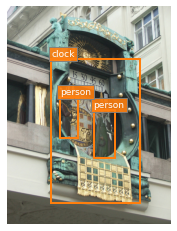

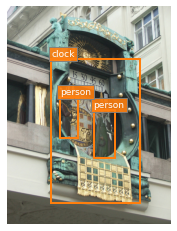

In [26]:
draw_gt_det_bboxes(data_info["img"][:,:,::-1], dets, data_info["ann_info"])